In [23]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import modules.evaluate as evaluate
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
import modules.random_graph as random_graph
import math
import random
import matplotlib.ticker as ticker
import pandas as pd


seeds= list(range(1000, 1020))
epis= ["Sars", "H1N1", "Covid", "ALL"]
epiIdx= 0 ###
n= 93
strains= 1
if epis[epiIdx]== "ALL":
    strains= 3

preAs= []
sumPreA= 0
for seed in seeds:
    fileName= f"AA/AA_{epis[epiIdx]}__{strains}_{n}_{seed}" #SARS_H1N1_COVID
    npzfile = np.load("results/"+fileName+".npz")
    PreA= torch.tensor(npzfile["Apre"])
    sumPreA+= PreA
    AdjCurTen= torch.tensor(npzfile["A"])
    AdjCur= AdjCurTen.numpy()
    signal= torch.tensor(npzfile["signal"])
    predSignal= torch.tensor(npzfile["predSignal"])
    preAs.append(PreA)
sumPreA= sumPreA/len(seeds)
preAs.append(sumPreA)
preAs.append(AdjCurTen)
for i in preAs:
    for j in preAs:
        print(np.round(evaluate.pearson_correlation(i, j).item(),2), end= ", ")
    print()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0, 0.85, 0.74, 0.77, 0.63, 0.74, 0.86, 0.83, 0.87, 0.8, 0.53, 0.64, 0.76, 0.77, 0.83, 0.79, 0.77, 0.65, 0.47, 0.57, 0.88, -0.02, 
0.85, 1.0, 0.67, 0.71, 0.64, 0.78, 0.86, 0.85, 0.87, 0.84, 0.57, 0.67, 0.79, 0.78, 0.85, 0.82, 0.8, 0.68, 0.47, 0.61, 0.89, -0.01, 
0.74, 0.67, 1.0, 0.89, 0.44, 0.55, 0.71, 0.67, 0.72, 0.63, 0.41, 0.46, 0.56, 0.61, 0.67, 0.62, 0.57, 0.55, 0.31, 0.42, 0.72, -0.0, 
0.77, 0.71, 0.89, 1.0, 0.48, 0.58, 0.74, 0.69, 0.75, 0.65, 0.41, 0.52, 0.6, 0.64, 0.69, 0.65, 0.61, 0.56, 0.33, 0.43, 0.75, -0.0, 
0.63, 0.64, 0.44, 0.48, 1.0, 0.66, 0.62, 0.6, 0.62, 0.66, 0.66, 0.71, 0.71, 0.66, 0.6, 0.66, 0.69, 0.63, 0.46, 0.62, 0.75, 0.02, 
0.74, 0.78, 0.55, 0.58, 0.66, 1.0, 0.74, 0.72, 0.74, 0.78, 0.52, 0.67, 0.82, 0.77, 0.73, 0.79, 0.78, 0.73, 0.55, 0.55, 0.84, -0.01, 
0.86, 0.86, 0.71, 0.74, 0.62, 0.74, 1.0, 0.86, 0.89, 0.83, 0.55, 0.65, 0.76, 0.77, 0.86, 0.8, 0.78, 0.65, 0.47, 0.6, 0.89,

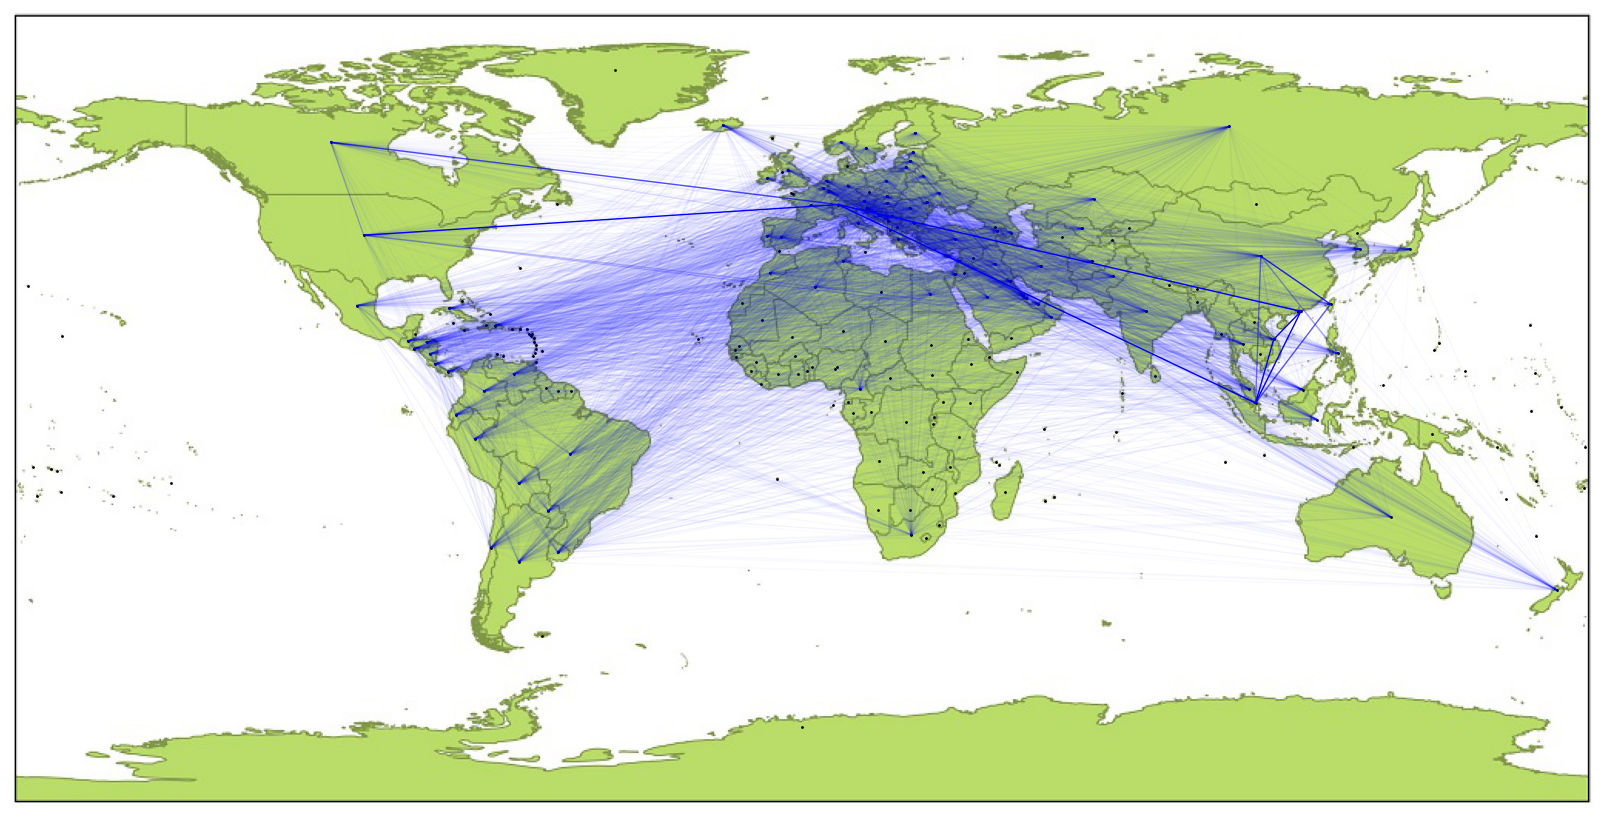

In [24]:


def plot_on_map(PreANp, realNp, lineWeightRatio= 10):
    pop_file_path = 'testData/Country_Population_final.csv'
    data = pd.read_csv(pop_file_path)
    popIdxData = np.genfromtxt(f'testData/test_pop_inx.csv', delimiter=',', skip_header=0)
    popIdxData= [int(i) for i in popIdxData]
    popIdxDataNp= np.array(popIdxData, dtype= "int")

    plt.figure(figsize=(10.28*2, 5.18*2))
    coordinatesArrayTmp= np.stack([data["loc_x"].to_numpy(), data["loc_y"].to_numpy()], axis= 1)
    img = plt.imread("WorldEqdc.jpg")
    plt.imshow(img)
    coordinatesArray= coordinatesArrayTmp.copy()
    coordinatesArray[:, 1]= 2.835*coordinatesArrayTmp[:, 1]+1028/2
    coordinatesArray[:, 0]= -2.835*coordinatesArrayTmp[:, 0]+518/2
    plt.scatter(coordinatesArray[:, 1], coordinatesArray[:, 0], color='black', s=1, label="Locations")
    # for i in range(len(popName)):
    #     plt.text(coordinatesArray[i, 1] + 0.1,
    #             coordinatesArray[i, 0] + 0.1, f"{popName[i]}", fontsize=10, color='black')  # Annotate points
    for i in range(realNp.shape[0]):
        for j in range(i + 1, realNp.shape[1]):  # Only upper triangle (undirected graph)
            if (realNp[j, i]+realNp[i, j])/2 > 1e-5 :# Only plot edges with weight > 0
                weight = (realNp[j, i]+realNp[i, j])/2
                plt.plot(
                    [coordinatesArray[popIdxDataNp[i], 1], coordinatesArray[popIdxDataNp[j], 1]],
                    [coordinatesArray[popIdxDataNp[i], 0], coordinatesArray[popIdxDataNp[j], 0]],
                    color='blue', alpha=min((weight)*lineWeightRatio, 1), linewidth= 1)
    for i in range(PreANp.shape[0]):
        for j in range(i + 1, PreANp.shape[1]):  # Only upper triangle (undirected graph)
            if (PreANp[j, i]+PreANp[i, j])/2 > 1e-5 :# Only plot edges with weight > 0
                weight = (PreANp[j, i]+PreANp[i, j])/2
                plt.plot(
                    [coordinatesArray[popIdxDataNp[i], 1], coordinatesArray[popIdxDataNp[j], 1]],
                    [coordinatesArray[popIdxDataNp[i], 0], coordinatesArray[popIdxDataNp[j], 0]],
                    color='orange', alpha=min((weight)*lineWeightRatio, 1), linewidth= 1)

    plt.axis('off')

portions= []
xs= []
TopNum= 50
APreNp= ((PreA)).cpu().detach().numpy()
rankedAPre= np.sort(APreNp.flatten())
ATrueNp= AdjCur/np.linalg.norm(AdjCur)
rankedATrue= np.sort(ATrueNp.flatten())
for TopNum in range(20, 1000):
    xs.append(((APreNp>rankedAPre[-TopNum])*APreNp).sum()/APreNp.sum())
    APreNpBi=  (APreNp>rankedAPre[-TopNum])*1.0
    ATrueNpBi= (ATrueNp>1e-9)*1.0
    portions.append(((APreNpBi*ATrueNpBi).sum())/APreNpBi.sum())
plot_on_map( 0*AdjCur/np.linalg.norm(AdjCur), PreA.cpu().detach().numpy(), 8)